In [1]:
import time
import joblib
import gc
import lightgbm as lgb
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score,
                           confusion_matrix,
                           ConfusionMatrixDisplay,
                           classification_report,
                           log_loss)
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [2]:
# actually training the LightBGM model
xtrain_path = 'models/X_train.npy'
xtest_path = 'models/X_test.npy'
ytrain_path = 'models/y_train.npy'
ytest_path = 'models/y_test.npy'
cat_ind_path = 'models/cat_ind.npy'

final_vectorizer_path = 'files/rating_vizer.pkl'
final_svd_path = 'files/rating_svd.pkl'

light_model_path = 'models/light_trained_rating.pkl'

final_test_df_path = 'files/final_test_df.csv'

X_train = np.load(xtrain_path)
X_test = np.load(xtest_path)
y_train = np.load(ytrain_path)
y_test = np.load(ytest_path)
categorical_features_indices = list(np.load(cat_ind_path))
categorical_features_indices = [int(i) for i in categorical_features_indices]

vizer = joblib.load(final_vectorizer_path)
svd = joblib.load(final_svd_path)

print(f'X_train shape : {X_train.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

verbose = True

X_train shape : (387864, 345)
X_test shape : (96967, 345)
y_train shape : (387864,)
y_test shape : (96967,)


In [3]:
early_stopping_callback = lgb.early_stopping(stopping_rounds = 50, verbose = True)
y_train_mapped = y_train - 1
y_train_mapped = y_train_mapped.astype(int)

y_test_mapped = y_test - 1
y_test_mapped = y_test_mapped.astype(int)

lgbm_quick = lgb.LGBMClassifier(
    objective='multiclass',
    metric='multi_logloss', 
    n_estimators=1000,      
    learning_rate=0.1,    
    num_leaves=21,           
    max_depth=15,             
    #subsample=0.7,           
    #colsample_bytree=0.7,    
    n_jobs=-1,              
    random_state=42
)

print('Starting training')
t0 = time.time()
early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=True)
lgbm_quick.fit(
    X_train,
    y_train_mapped,
    eval_set=[(X_test, y_test_mapped)],
    eval_metric='multi_logloss', 
    callbacks=[early_stopping_callback]
)

finish_time = time.time()

Starting training
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.475488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77413
[LightGBM] [Info] Number of data points in the train set: 387864, number of used features: 345
[LightGBM] [Info] Start training from score -1.836153
[LightGBM] [Info] Start training from score -2.572644
[LightGBM] [Info] Start training from score -2.332083
[LightGBM] [Info] Start training from score -1.598895
[LightGBM] [Info] Start training from score -0.765667
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.783309


In [4]:
if verbose:
    print(f'Finished training after {finish_time - t0} seconds.\n')
print(f"Model stopped at iteration: {lgbm_quick.best_iteration_}")
best_lgbm = lgbm_quick
joblib.dump(best_lgbm, light_model_path)
print(f'Best LightGBM model saved at {light_model_path}.')

Finished training after 469.80377769470215 seconds.

Model stopped at iteration: 1000
Best LightGBM model saved at models/light_trained_rating.pkl.


In [5]:
# for predicting on chunks that were never trained on
final_df = pd.read_csv(final_test_df_path) # read the dataframe in
display(final_df.head(10))

# splits the final data frame into the parts we're going to use
drop_cols = ['user_id', 'business_id']


final_df = final_df.drop(drop_cols, axis=1)
# convert broad_category to numeric
label_encoder = LabelEncoder()

final_df = final_df.convert_dtypes()

categorical_features = ['ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'BikeParking',
       'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'RestaurantsDelivery',
       'Caters', 'WiFi', 'WheelchairAccessible', 'HappyHour', 'OutdoorSeating',
       'HasTV', 'RestaurantsReservations', 'DogsAllowed', 'Alcohol',
       'GoodForKids', 'RestaurantsAttire', 'RestaurantsTableService',
       'RestaurantsGoodForGroups', 'NoiseLevel', 'BusinessAcceptsBitcoin',
       'BusinessParking_garage', 'BusinessParking_street',
       'BusinessParking_validated', 'BusinessParking_lot',
       'BusinessParking_valet', 'Ambience_romantic', 'Ambience_intimate',
       'Ambience_touristy', 'Ambience_hipster', 'Ambience_divey',
       'Ambience_classy', 'Ambience_trendy', 'Ambience_upscale',
       'Ambience_casual', 'GoodForMeal_dessert', 'GoodForMeal_latenight',
       'GoodForMeal_lunch', 'GoodForMeal_dinner', 'GoodForMeal_brunch',
       'GoodForMeal_breakfast', 'broadCategory']

# replace -1 with 'unknown' so that encoder works
string_cols = final_df.select_dtypes(include='string').columns
final_df[string_cols] = final_df[string_cols].astype(object).replace(-1, 'Unknown')
final_df[string_cols] = final_df[string_cols].astype(object).replace(np.nan, 'Unknown')

# encode the categorical featurs
final_df[categorical_features] = final_df[categorical_features].apply(label_encoder.fit_transform)
categorical_features_indices = [final_df.columns.get_loc(name) for name in categorical_features]

check_cols = [
    'ByAppointmentOnly', 
    'RestaurantsPriceRange2',
    'BusinessAcceptsCreditCards',
    'RestaurantsPriceRange2',
    'account_age_years',
    'review_count_x'
]
final_df = final_df.dropna(subset = check_cols)

y = final_df['stars']
print(f'y true is {y}')
y_true = y - 1
y_true = y_true.astype(int)

print(f'y true now is {y}')

final_df = final_df.drop(['stars'], axis=1)

t0 = time.time()
print('Starting vectorization')

# vectorize review text with tf-idf
x_text = vizer.transform(final_df['text'])
x_text_reduced = svd.transform(x_text)

# reduce the text size
text_reduced = x_text_reduced.astype(np.float32)
print(f'text vectorized after {time.time() - t0} seconds')

final_df = final_df.drop(['text'], axis = 1)

if verbose:
    display(final_df.info())

# save categorical_features for training the model
np.save(cat_ind_path, categorical_features_indices)
# can't have any null values
if verbose:
    print(final_df.isnull().any())

# force everything to be float32 to save on memory
final_values = final_df.values.astype(np.float32)

print(f"\nMemory usage of X: {final_values.nbytes / (1024**2):.2f} MB\n")
print(f'final_values data types: {final_values.dtype}')

,user_id,business_id,stars,text,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,RestaurantsDelivery,...,GoodForMeal_dessert,GoodForMeal_latenight,GoodForMeal_lunch,GoodForMeal_dinner,GoodForMeal_brunch,GoodForMeal_breakfast,review_count_x,broadCategory,review_count_y,account_age_years
0,aqDcLzgXlFzlU-Sc1bTHUw,9X2rQUHO_ka0k7tu7wr_7g,1.0,we were greeted nicely and seated right away t...,-1.0,1.0,1.0,2.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,-1.0,-1.0,83.0,14.0,36.0,14.798084
1,bxTEp0AbmdXEAxmEIhfm_g,f2YXWEafk6m0fiHZjp8Y8w,5.0,had a wonderful ribeye and great service the ...,-1.0,1.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,130.0,14.0,13.0,13.927447
2,7BDIqQI2ffaAN9OZbZCUhw,XqSLir6xs3I6ntf-xIQzrQ,2.0,we went to city house with high expectations f...,-1.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,711.0,14.0,14.0,14.811773
3,fDtLSbdd8A3UaXiDMGcUuw,56p17O_bHVEPBh4m41JAsA,5.0,just bought an incredible piece of clothing a ...,0.0,1.0,1.0,2.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,76.0,15.0,6.0,10.160164
4,Z5E-JeUUZD9S_Ft8SZSlmQ,JyOfFuVEGnhLdoN3K1WewQ,5.0,im here several times a week if not more food...,-1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,126.0,14.0,4.0,11.485284
5,3sEfDD6GRXSg637-p-ntFg,Dbgv4FjJ89mkhRz9fefBpw,5.0,the new owner franco was great the food was f...,-1.0,1.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,255.0,14.0,25.0,10.365503
6,HuJ1A2yzHv5W0UIhNUKtsg,ETsHfis7Dm932TS0dRjcoQ,4.0,dont sit around reading yelp reviewsgo to the ...,-1.0,1.0,1.0,2.0,1.0,1.0,...,-1.0,-1.0,1.0,1.0,-1.0,-1.0,256.0,14.0,15.0,10.234086
7,dHhFcBQVny1EqAhLTI9b1Q,Rl1NN7QH08h5h0XO00lPFA,1.0,32 dollars for two nasty grilled cheeses and t...,-1.0,1.0,1.0,2.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,246.0,14.0,21.0,7.786448
8,_0IDwhh2lDeBj5k6mKwcLg,_YfdFmhYhaelhlQXoGCktA,4.0,well this is a welcome addition to the french ...,-1.0,1.0,1.0,2.0,1.0,1.0,...,-1.0,0.0,1.0,0.0,1.0,1.0,150.0,14.0,35.0,14.748802
9,T1fINCHLQ4d-3Ppso_Z0DQ,5IvBJJl3bemFixZ9uh_wXg,2.0,though i love this place to go for a drink and...,-1.0,1.0,1.0,2.0,1.0,1.0,...,0.0,-1.0,-1.0,1.0,0.0,0.0,625.0,14.0,45.0,9.752225


y true is 0         1
1         5
2         2
3         5
4         5
         ..
500007    5
500008    5
500009    4
500010    4
500011    5
Name: stars, Length: 482731, dtype: Int64
y true now is 0         1
1         5
2         2
3         5
4         5
         ..
500007    5
500008    5
500009    4
500010    4
500011    5
Name: stars, Length: 482731, dtype: Int64
Starting vectorization
text vectorized after 30.899317979812622 seconds
<class 'pandas.core.frame.DataFrame'>
Index: 482731 entries, 0 to 500011
Data columns (total 45 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ByAppointmentOnly           482731 non-null  int64  
 1   BusinessAcceptsCreditCards  482731 non-null  int64  
 2   BikeParking                 482731 non-null  int64  
 3   RestaurantsPriceRange2      482731 non-null  int64  
 4   RestaurantsTakeOut          482731 non-null  int64  
 5   RestaurantsDelivery         482731 non-

None

ByAppointmentOnly             False
BusinessAcceptsCreditCards    False
BikeParking                   False
RestaurantsPriceRange2        False
RestaurantsTakeOut            False
RestaurantsDelivery           False
Caters                        False
WiFi                          False
WheelchairAccessible          False
HappyHour                     False
OutdoorSeating                False
HasTV                         False
RestaurantsReservations       False
DogsAllowed                   False
Alcohol                       False
GoodForKids                   False
RestaurantsAttire             False
RestaurantsTableService       False
RestaurantsGoodForGroups      False
NoiseLevel                    False
BusinessAcceptsBitcoin        False
BusinessParking_garage        False
BusinessParking_street        False
BusinessParking_validated     False
BusinessParking_lot           False
BusinessParking_valet         False
Ambience_romantic             False
Ambience_intimate           

In [6]:
# Crash point warning!!!
X_final = np.hstack((final_values,x_text_reduced))

print(X_final)

# dump what we can
del x_text_reduced, final_values
gc.collect()

[[ 0.00000000e+00  2.00000000e+00  2.00000000e+00 ...  6.04072470e-03
   2.39325151e-03 -2.29821478e-02]
 [ 0.00000000e+00  2.00000000e+00  2.00000000e+00 ... -5.60713498e-03
   8.90944070e-03  4.39346179e-03]
 [ 0.00000000e+00  2.00000000e+00  2.00000000e+00 ...  3.25348638e-02
  -1.92801278e-03 -2.46235828e-02]
 ...
 [ 1.00000000e+00  2.00000000e+00  2.00000000e+00 ...  3.17512246e-03
  -1.27685917e-03 -1.93451498e-02]
 [ 1.00000000e+00  2.00000000e+00  2.00000000e+00 ...  2.14299200e-02
  -9.37018052e-03  2.41133085e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ...  7.48273104e-03
  -3.92739449e-03  1.58321178e-02]]


8

/home/thomas/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[3 4 1 ... 4 3 4]
Overall Accuracy: 0.6486

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     63477
           1       0.41      0.25      0.31     38557
           2       0.45      0.31      0.37     52413
           3       0.51      0.43      0.46    111689
           4       0.73      0.87      0.80    216595

    accuracy                           0.65    482731
   macro avg       0.56      0.53      0.54    482731
weighted avg       0.62      0.65      0.63    482731


Confusion Matrix:


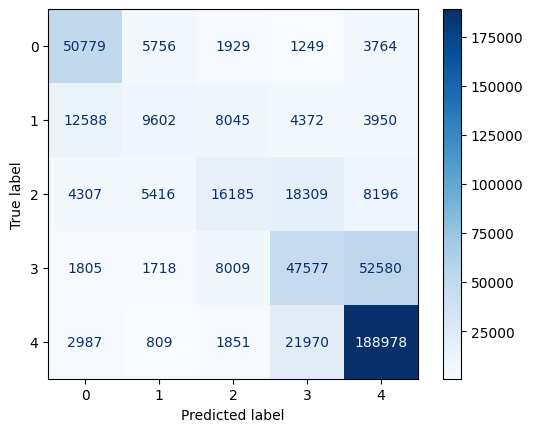

In [7]:
y_pred = best_lgbm.predict(X_final)

print(y_pred)
# --- Basic Accuracy ---
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.4f}")

# --- Classification Report ---
class_labels = [0, 1, 2, 3, 4] 
report = classification_report(y_true, y_pred, target_names=[str(label) for label in class_labels])
print("\nClassification Report:")
print(report)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels))) # Ensure labels cover 0-4 or 1-5
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(label) for label in class_labels])

print("\nConfusion Matrix:")
# print(cm) # Print the raw matrix numbers

disp.plot(cmap=plt.cm.Blues)
plt.show()
